# Comparing linear reservoir calibrations
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 13-06-2024<br>

**Introduction:**<br>


**To do:**<br>


**Ideas:**<br>

In [3]:
import sys
sys.path.append('../../src/')
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import yaml
from pathlib import Path
import xarray as xr
from tqdm.notebook import tqdm
from datetime import timedelta

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from lisfloodreservoirs.reservoirs.linear import Linear
from lisfloodreservoirs.utils.metrics import KGEmod, ECDF
from lisfloodreservoirs.utils.plots import create_cmap

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [8]:
# config plots
proj = ccrs.PlateCarree()
extent = [-125, -67.5, 24, 51]

catchment_pol = gpd.read_file('../../GIS/catchments_US.shp')
catchment_pol = catchment_pol.to_crs(proj)#'epsg:4326')

In [9]:
sns.set_style('ticks')

## Configuration

In [48]:
with open('config_linear_2var.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
### Paths

PATH_RES_NC = Path(cfg['paths']['reservoirs']['netcdf'])
PATH_RES_SHP = Path(cfg['paths']['reservoirs']['shapefile'])
PATH_DATASETS = Path(cfg['paths']['dataset'])

### Reservoir model

MODEL = cfg['model'].lower()

# plots will be saved in this path
PATH_OUT = Path(f'{MODEL}/calibration/comparison')
PATH_OUT.mkdir(parents=True, exist_ok=True)
print(f'Results will be saved in {PATH_OUT}')

Results will be saved in linear\calibration\comparison


In [11]:
# results will be saved in this path
path_results = Path(f'./{MODEL}')
paths = {'default': path_results / 'default',
         'SCEUA-Q': path_results / 'calibration' / 'sceua' / 'univariate' / 'outflow',
         'SCEUA-S': path_results / 'calibration' / 'sceua' / 'univariate' / 'storage',
         'SCEUA-QS': path_results / 'calibration' / 'sceua' / 'bivariate'}

In [12]:
par_space = {'T': (90, 1100)}

## Data

### GloFAS

#### Reservoirs

In [180]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file(PATH_RES_SHP)
reservoirs.set_index('ResID', drop=True, inplace=True)

print(f'{reservoirs.shape[0]} reservoirs in the shape file')

94 reservoirs in the shape file


#### Time series

In [17]:
# read GloFAS time series
path = Path('../../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs in the GloFAS time series')

# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

# period of GloFAS simulation
start, end = glofas_ts[id].first_valid_index(), glofas_ts[id].last_valid_index()

  0%|          | 0/143 [00:00<?, ?it/s]

94 reservoirs in the GloFAS time series


### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [249]:
# load GRanD data set
path_GRanD = PATH_DATASETS / 'GRanD' / 'v1_3'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# extract reservoirs of interes
grand = grand.loc[reservoirs.GRAND_ID]

In [250]:
# define single-use reservoirs
grand['SINGLE_USE'] = (~grand[[col for col in grand.columns if ('USE' in col) & (col != 'MAIN_USE')]].isnull()).sum(axis=1) == 1

In [251]:

reservoirs['MAIN_USE'] = grand.loc[reservoirs.GRAND_ID, 'MAIN_USE'].values
reservoirs['SINGLE_USE'] = grand.loc[reservoirs.GRAND_ID, 'SINGLE_USE'].values

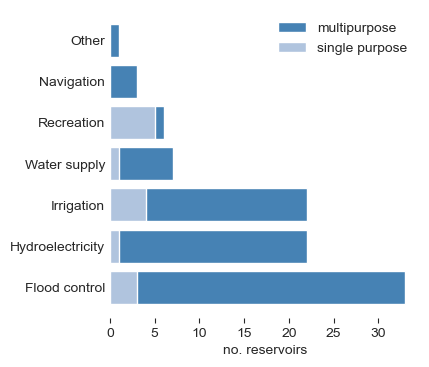

In [252]:
use_summary_singlepurpose = reservoirs.loc[reservoirs.SINGLE_USE, 'MAIN_USE'].value_counts()
use_summary_multipurpose = reservoirs['MAIN_USE'].value_counts()

fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(use_summary_multipurpose.index, use_summary_multipurpose.values, color='steelblue', label='multipurpose')
ax.barh(use_summary_singlepurpose.index, use_summary_singlepurpose.values, color='lightsteelblue', label='single purpose')
ax.set(#title='Reservoir main use',
       xlabel='no. reservoirs')
ax.tick_params(axis='y', length=0)
ax.legend(loc=1, frameon=False)
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);

plt.savefig(PATH_OUT / 'reservoir_main_use.jpg', dpi=300, bbox_inches='tight');

### ResOpsUS
#### Time series

In [26]:
path_ResOps = Path(PATH_DATASETS / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

print(f'{len(resops_ts)} reservoirs in the ResOpsUS time series')
    
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

  0%|          | 0/94 [00:00<?, ?it/s]

94 reservoirs in the ResOpsUS time series


## Performance

In [181]:
metrics = ['KGE', 'alpha', 'beta', 'rho']
variables = ['inflow', 'outflow', 'storage']
performance = {sampling: {var: pd.DataFrame(columns=metrics, dtype=float) for var in variables} for sampling in ['GloFAS'] + list(paths)}
parameters = {sampling: pd.DataFrame(columns=list(par_space), dtype=float) for sampling in list(paths)}

### Benchmark: GloFAS

for ResID, sim in glofas_ts.items():
    obs = resops_ts[ResID][variables].copy()
    obs[obs < 0] = np.nan
    for var in sim.columns:
        try:
            performance['GloFAS'][var].loc[ResID] = KGEmod(obs[var], sim[var])
        except:
            continue

### Calibrations

for sampling, path in tqdm(paths.items()):

    # read and reformat performance
    perf_files = path.glob('*_performance.csv')
    for file in tqdm(list(perf_files), desc='reading performance files'):
        ResID = int(file.stem.split('_')[0])
        perf = pd.read_csv(file, index_col=0)[variables]
        for var, df in performance[sampling].items():
            df.loc[ResID] = perf[var]

    # read and reformat parameters
    par_files = path.glob('*_parameters.yml')
    for file in tqdm(list(par_files), desc='reading parameter files'):
        ResID = int(file.stem.split('_')[0])
        with open(file, 'r', encoding='utf8') as ymlfile:
            pars = yaml.load(ymlfile, Loader=yaml.FullLoader)
        pars = pd.DataFrame({ResID: pars}).transpose()
        parameters[sampling].loc[ResID, pars.columns] = pars.loc[ResID].values

# convert results to Datasets
parameters = xr.Dataset({sampling: xr.DataArray(df, dims=['ResID', 'parameter']) for sampling, df in parameters.items()})
performance = xr.Dataset({sampling: xr.Dataset({var: xr.DataArray(df, dims=['ResID', 'metric']) for var, df in dct.items()}).to_array(dim='variable') for sampling, dct in performance.items()})

# limit reservoirs to those for which parameters were optimized
ResIDs = list(set(parameters.ResID.data).intersection(performance.ResID.data))
reservoirs = reservoirs.loc[ResIDs]

print('no reservoirs:', len(ResIDs))

  0%|          | 0/4 [00:00<?, ?it/s]

reading performance files:   0%|          | 0/94 [00:00<?, ?it/s]

reading parameter files:   0%|          | 0/94 [00:00<?, ?it/s]

reading performance files:   0%|          | 0/94 [00:00<?, ?it/s]

reading parameter files:   0%|          | 0/94 [00:00<?, ?it/s]

reading performance files:   0%|          | 0/88 [00:00<?, ?it/s]

reading parameter files:   0%|          | 0/88 [00:00<?, ?it/s]

reading performance files:   0%|          | 0/89 [00:00<?, ?it/s]

reading parameter files:   0%|          | 0/89 [00:00<?, ?it/s]

no reservoirs: 94


## Analysis
### Performance

In [189]:
# KGE bivariate
KGE_bivar = xr.Dataset({sampling: 1 - ((1 - da.sel(metric='KGE'))**2).sum('variable')**.5 for sampling, da in performance.items()})
KGE_bivar = KGE_bivar.to_pandas().drop('metric', axis=1)

In [207]:
sample_color = {'GloFAS': 'k',
                'default': 'purple',
                'SCEUA-Q': 'gold',
                'SCEUA-S': 'salmon',#'khaki',
                'SCEUA-QS': 'steelblue',
                'MC-QS': 'lightsteelblue'}

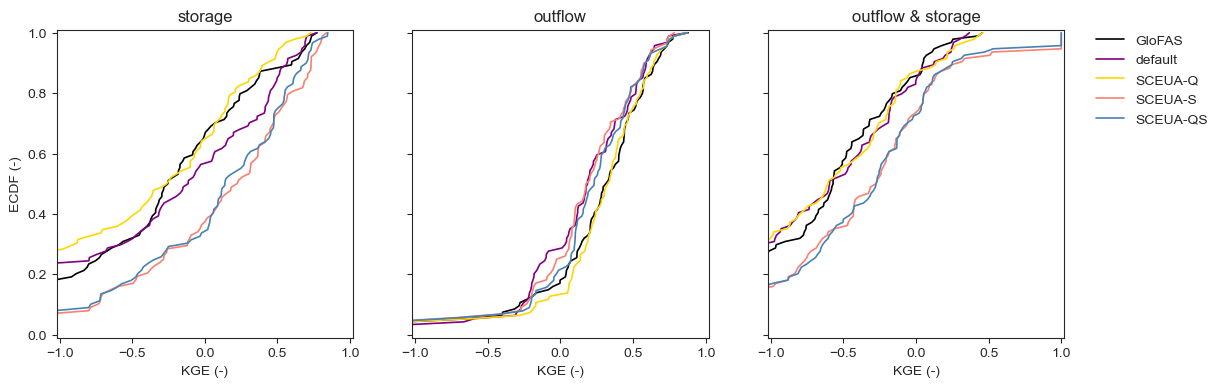

In [208]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)
for ax, var in zip(axes, ['storage', 'outflow']):
    for sampling, da in performance.items():
        ecdf = ECDF(da.sel(metric='KGE', variable=var).to_pandas(), plot=False)
        ax.plot(ecdf.values, ecdf.index, c=sample_color[sampling], lw=1.2, label=sampling)
    ax.set(xlabel='KGE (-)',
           title=var)
    if ax == axes[0]:
        ax.set_ylabel('ECDF (-)')

ax = axes[2]
for sampling in KGE_bivar.columns:
    ecdf = ECDF(KGE_bivar[sampling], plot=False)
    ax.plot(ecdf.values, ecdf.index, c=sample_color[sampling], lw=1.2, label=sampling)
    
ax.set(xlim=(-1.02, 1.02),
       ylim=(-.01, 1.01),
       xlabel='KGE (-)',
       title='outflow & storage')
    
fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .6, .1, .3]);

plt.savefig(PATH_OUT / f'ecdf_KGE.jpg', dpi=300, bbox_inches='tight');

Divide the previous by use.

In [193]:
use_color = {'Flood control': 'steelblue', 'Hydroelectricity': 'salmon', 'Irrigation': 'gold'}

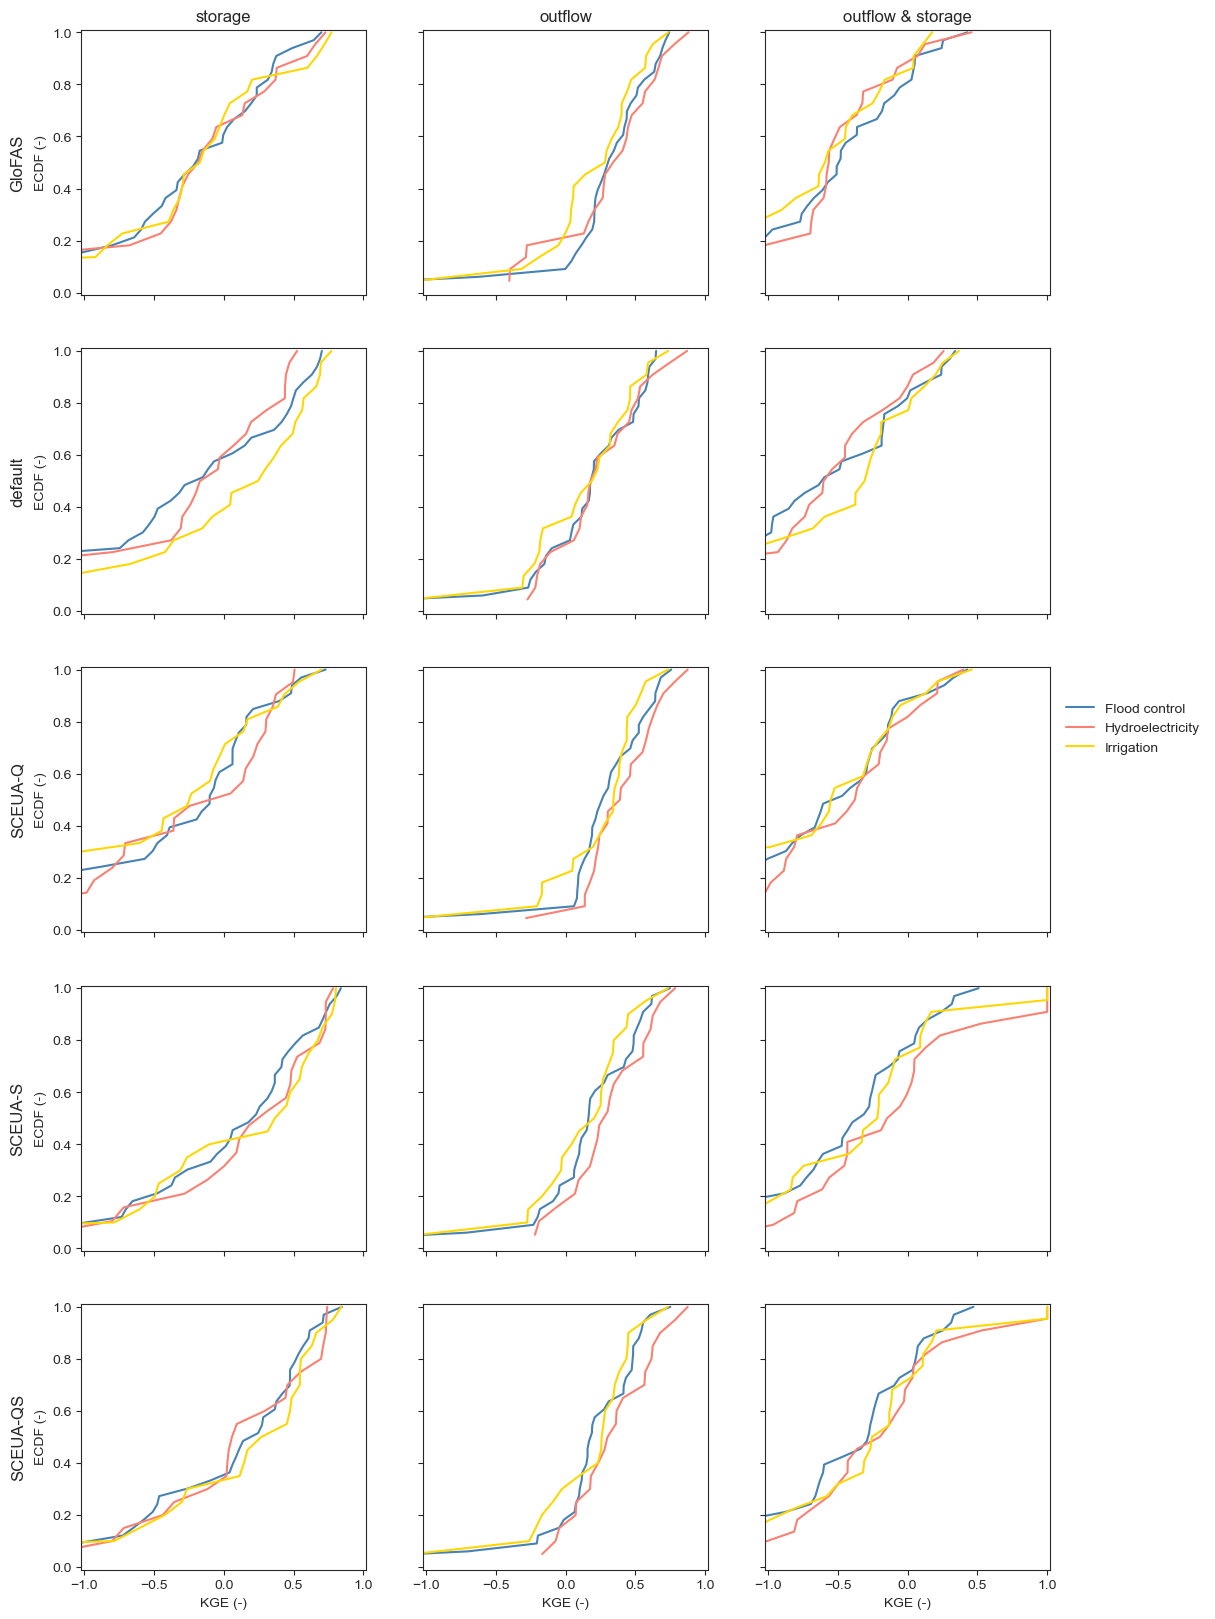

In [262]:
nrows = len(performance)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(12.5, 4 * nrows), sharex=True, sharey=True)
for i, (sampling, da) in enumerate(performance.items()):
    
    for j, var in enumerate(['storage', 'outflow']):
        ax = axes[i,j]
        for use in ['Flood control', 'Hydroelectricity', 'Irrigation']:
            ResIDs = reservoirs[reservoirs.MAIN_USE == use].index
            ecdf = ECDF(performance[sampling].sel(metric='KGE', variable=var, ResID=ResIDs).to_pandas(), plot=False)
            ax.plot(ecdf.values, ecdf.index, c=use_color[use], label=use)
        if i == 0:
            ax.set_title(var)
        elif i == nrows - 1:
            ax.set_xlabel('KGE (-)')
        if j == 0:
            ax.set_ylabel('ECDF (-)')
            ax.text(-.25, .5, sampling, fontsize=12, rotation=90, va='center', transform=ax.transAxes)

    ax = axes[i, 2]
    for use in ['Flood control', 'Hydroelectricity', 'Irrigation']:
        ResIDs = reservoirs[reservoirs.MAIN_USE == use].index
        ecdf = ECDF(KGE_bivar.loc[ResIDs, sampling], plot=False)
        ax.plot(ecdf.values, ecdf.index, c=use_color[use], label=use)
    ax.set(xlim=(-1.02, 1.02),
           ylim=(-.01, 1.01))
    if i == 0:
            ax.set_title('outflow & storage')
    elif i == nrows - 1:
        ax.set_xlabel('KGE (-)')
    if j == 0:
        ax.set_ylabel('ECDF (-)')

fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .45, .11, .1]);

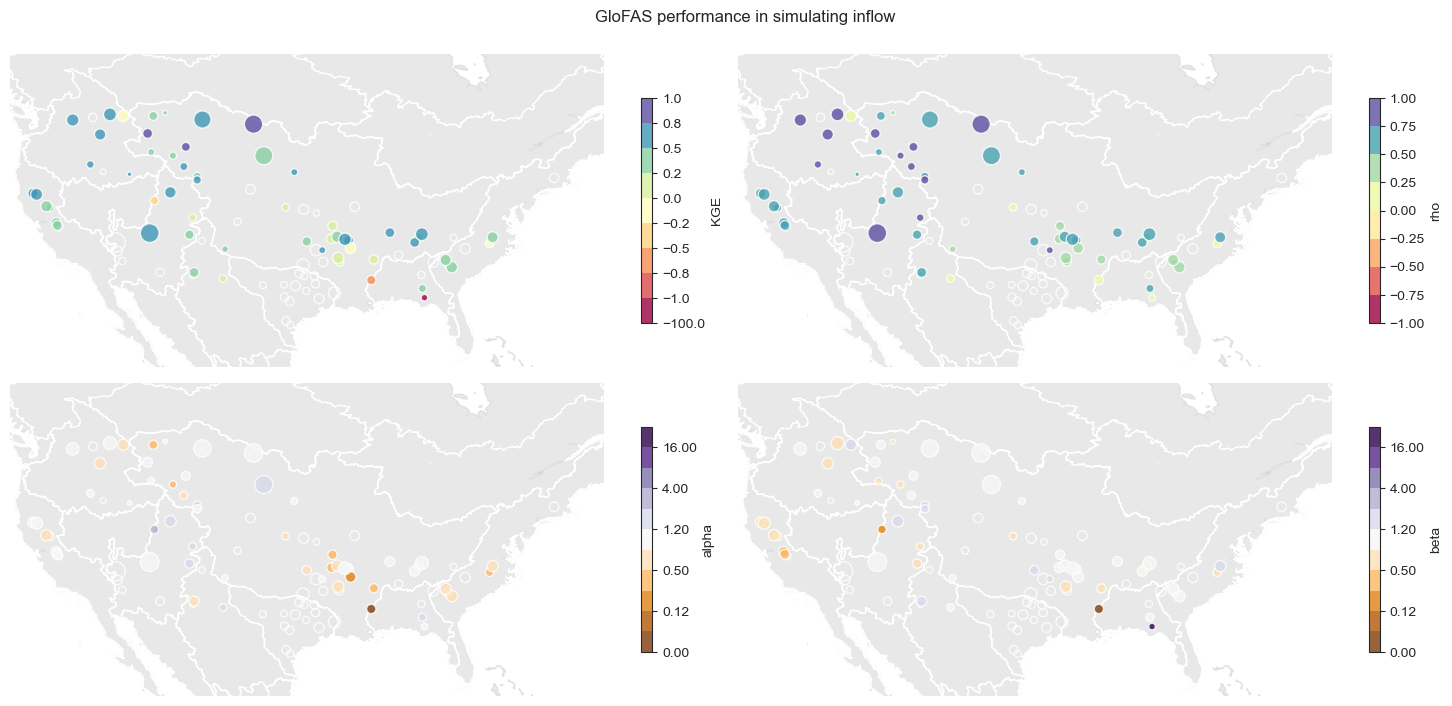

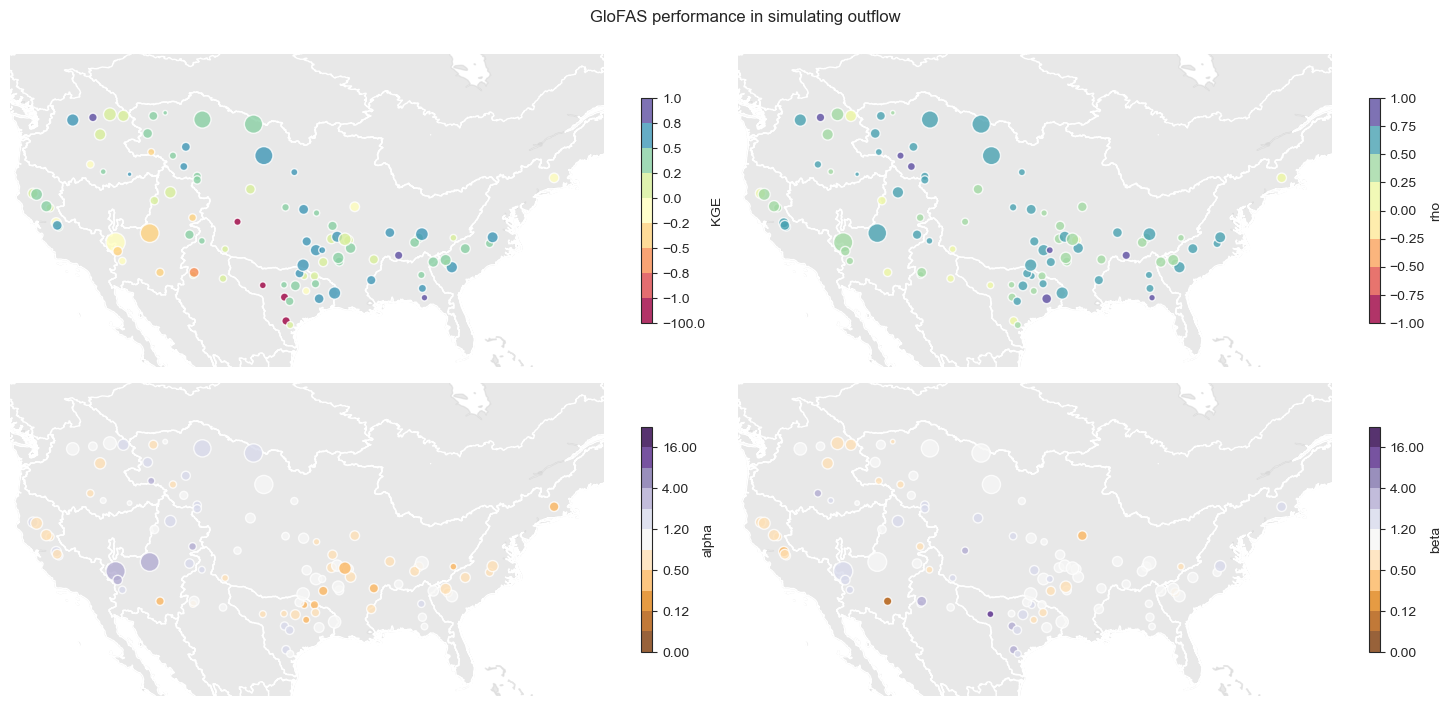

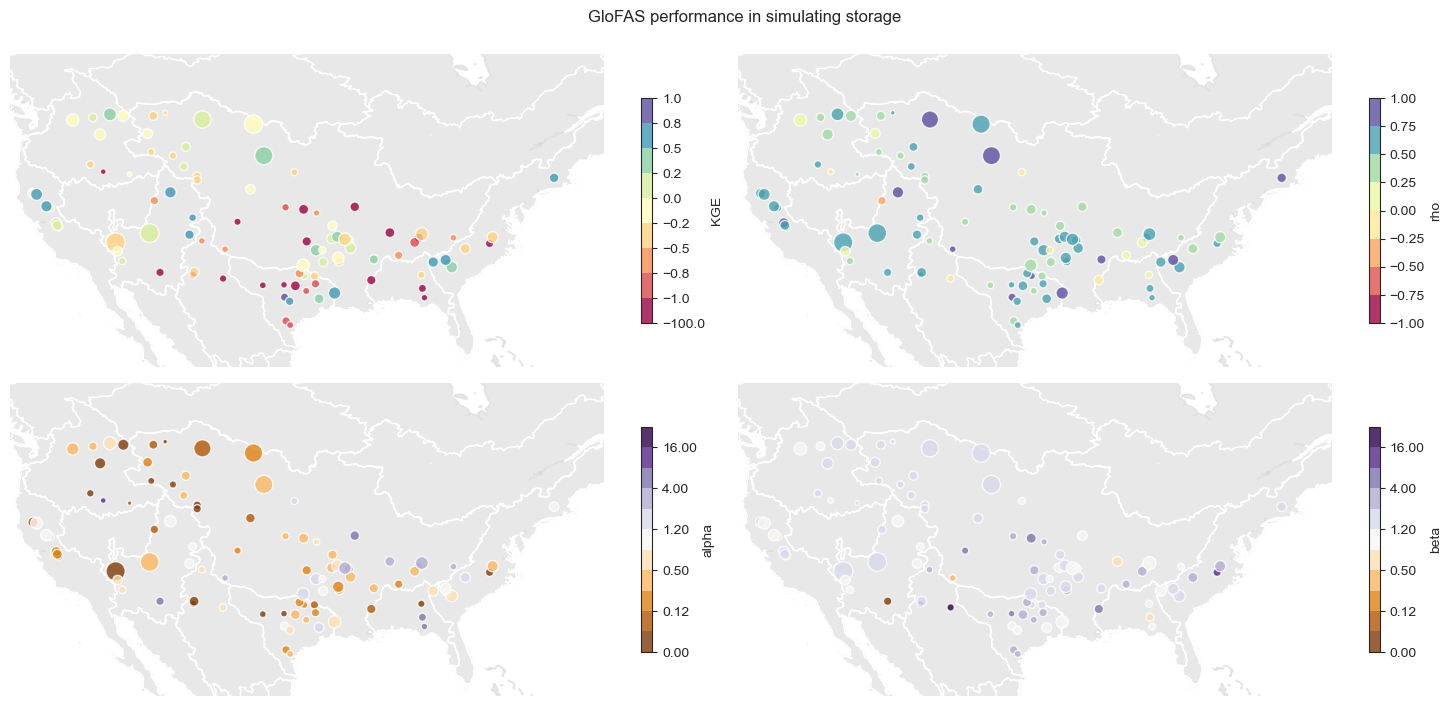

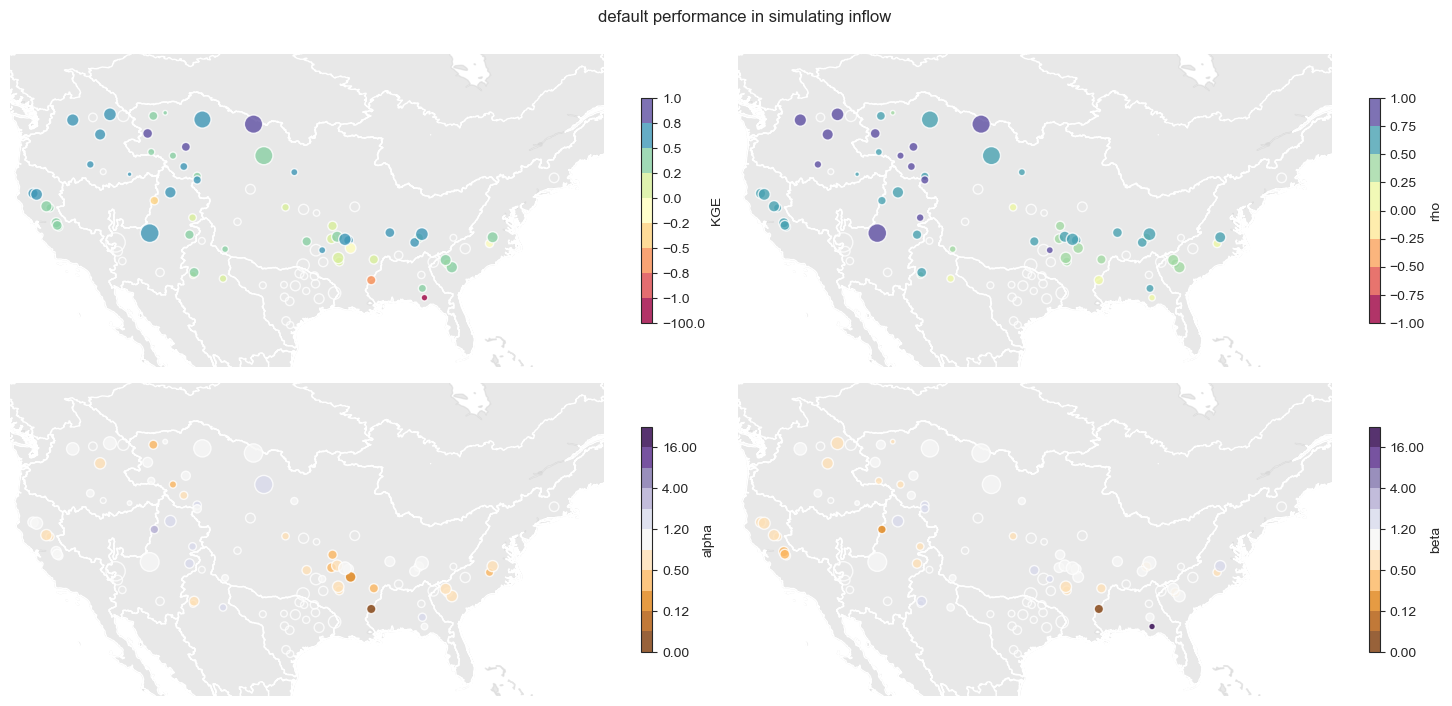

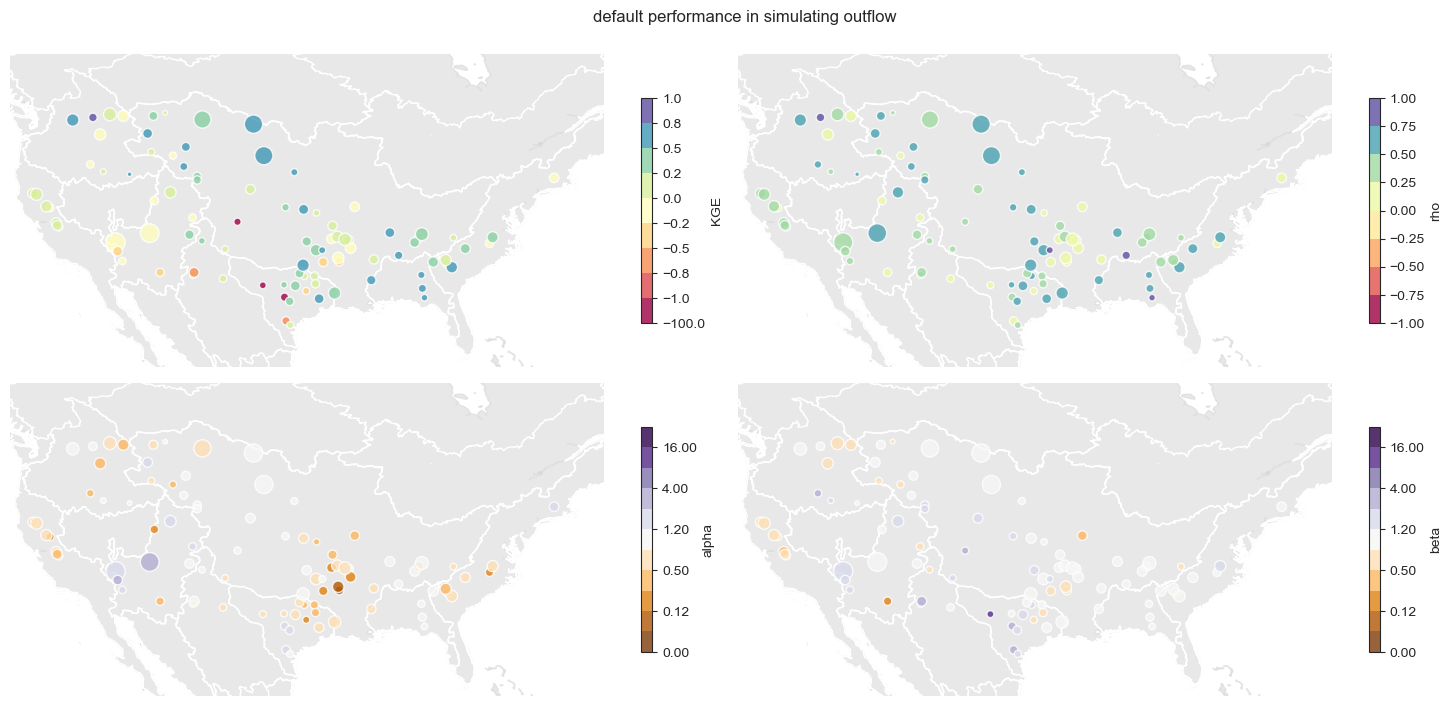

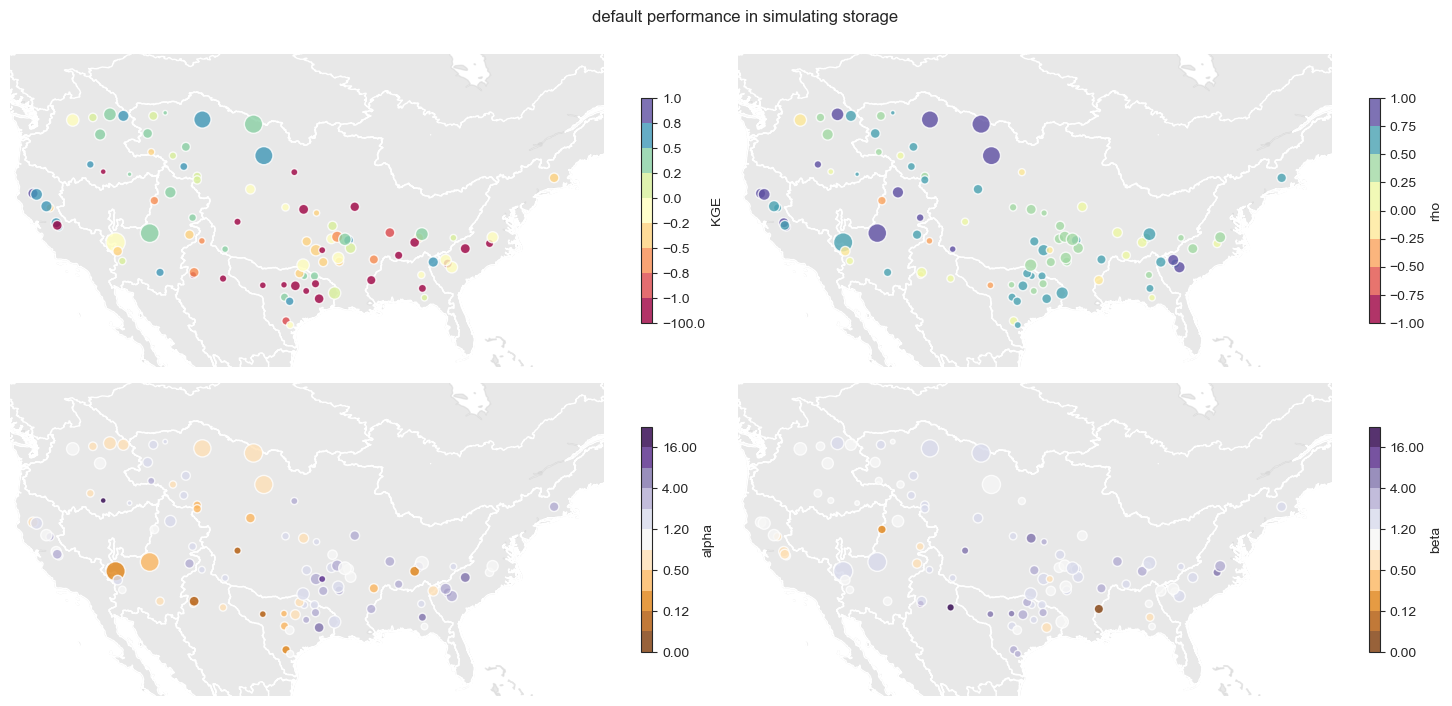

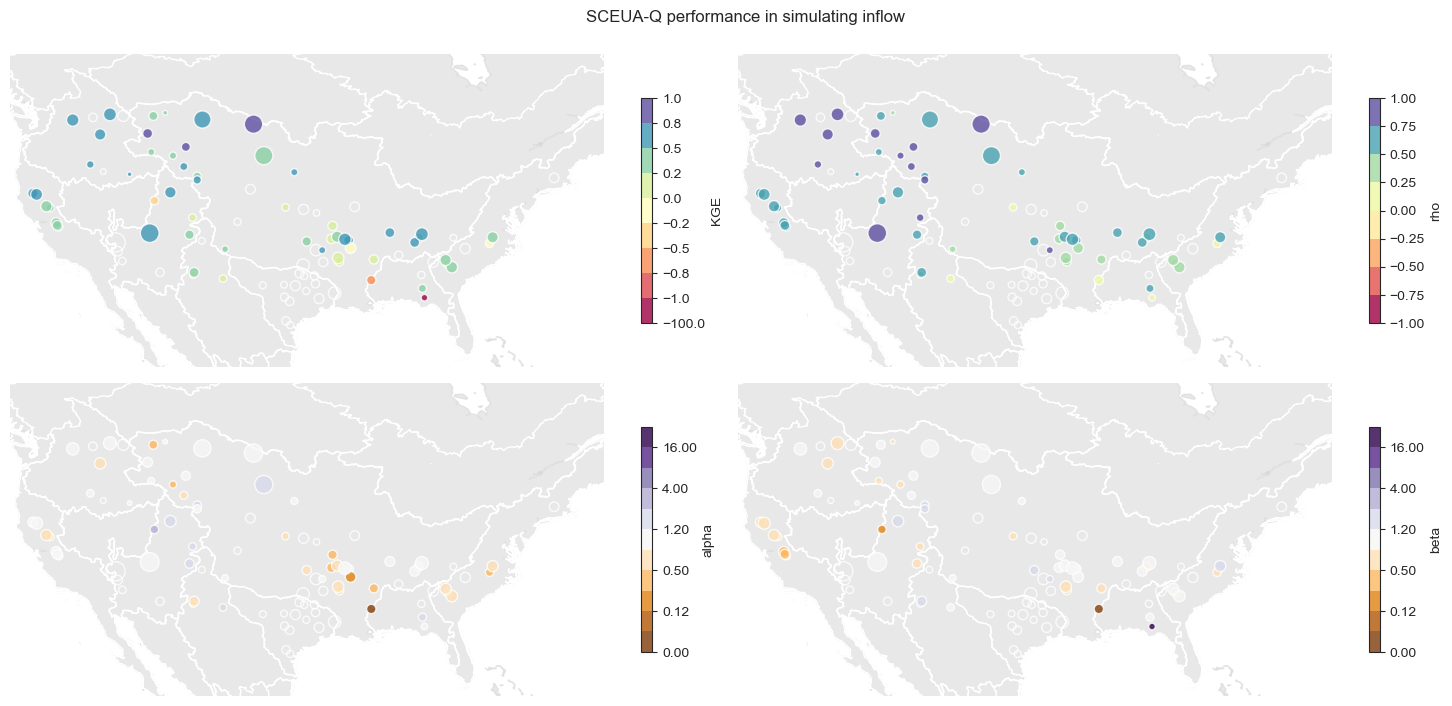

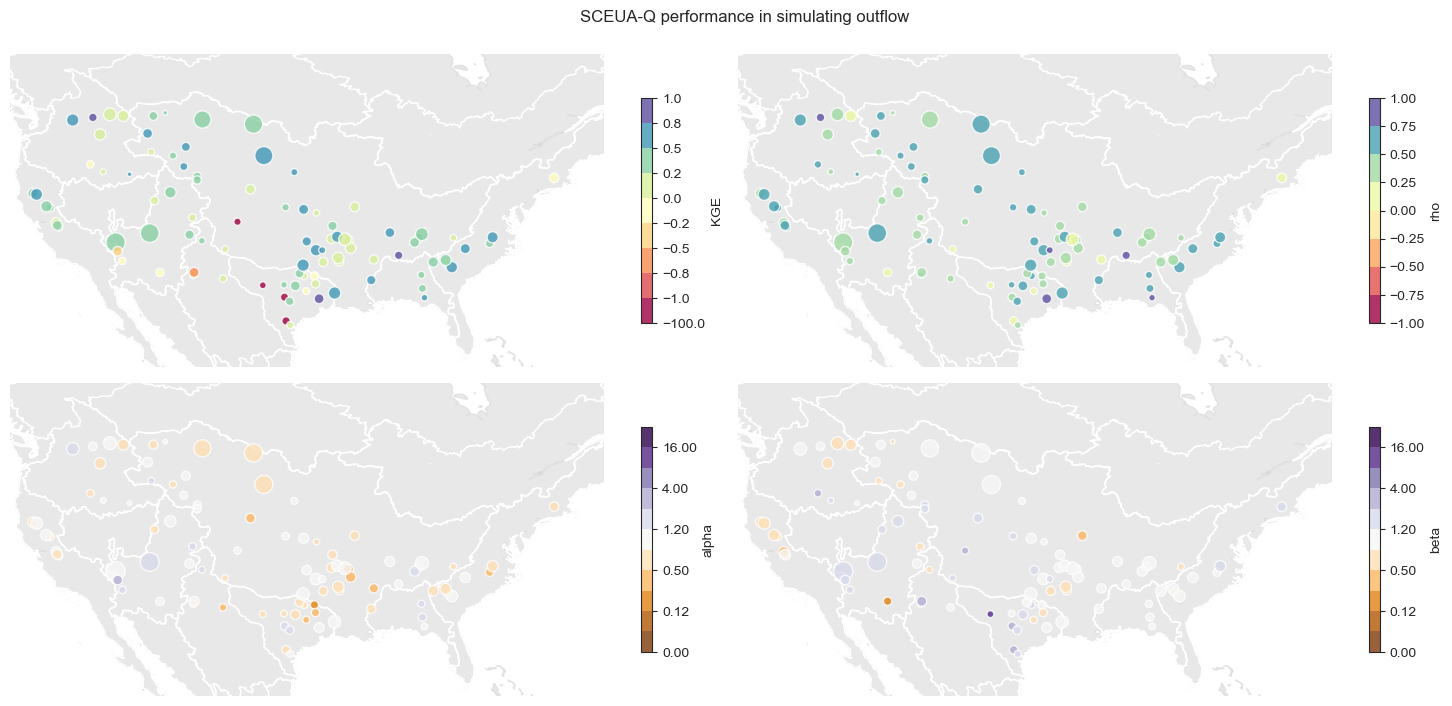

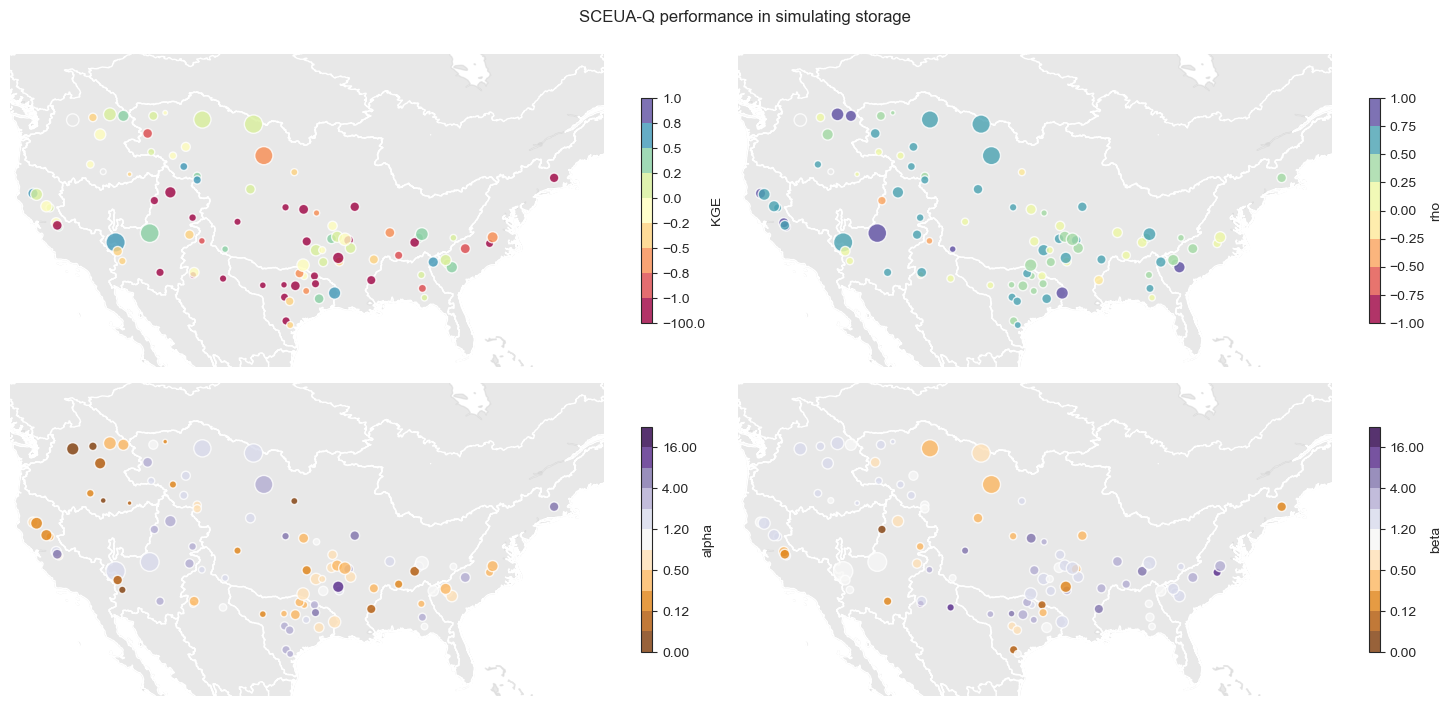

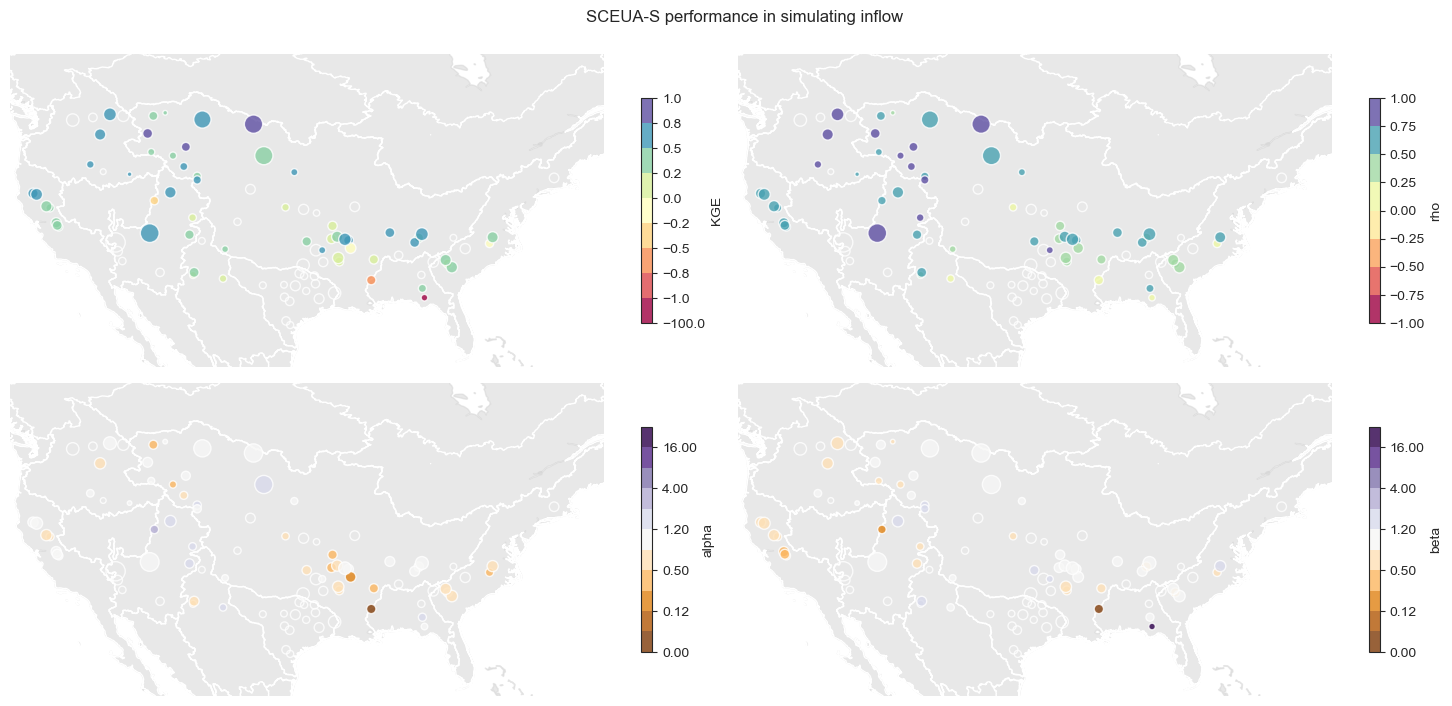

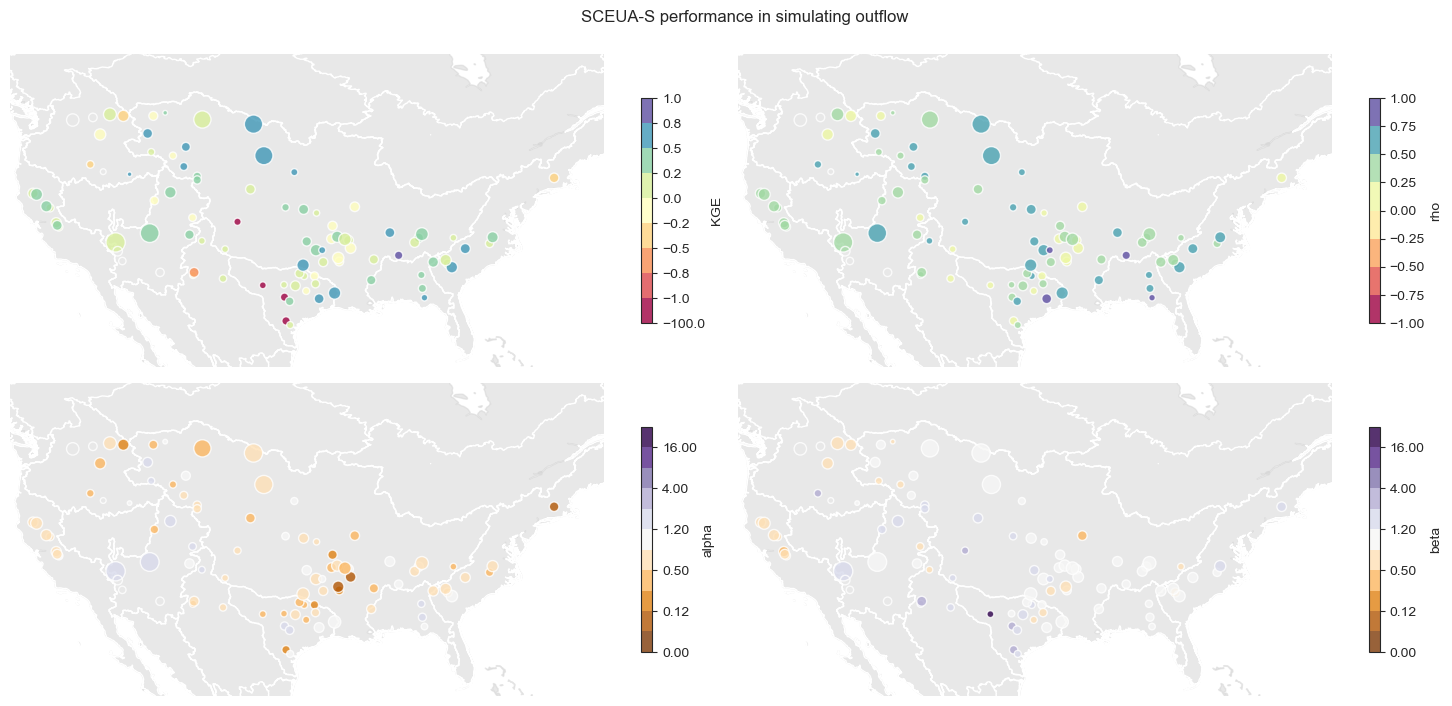

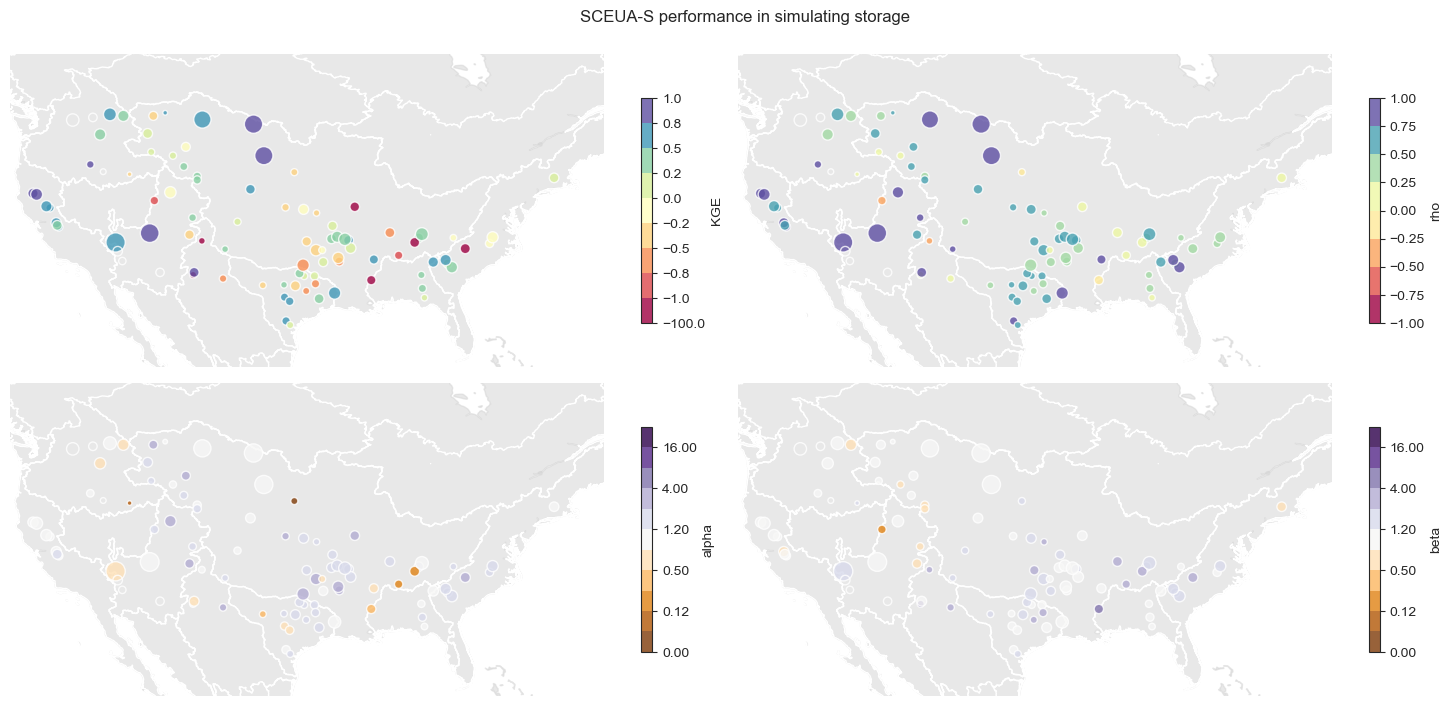

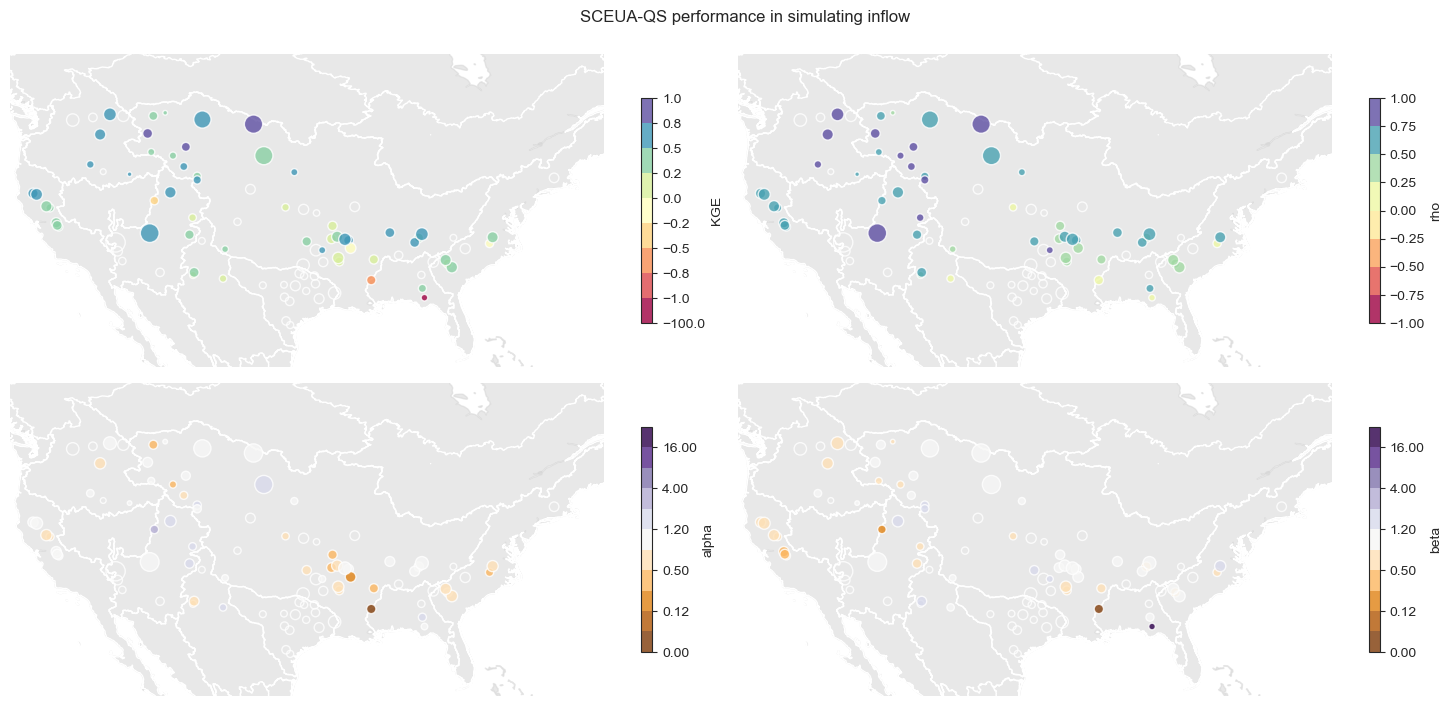

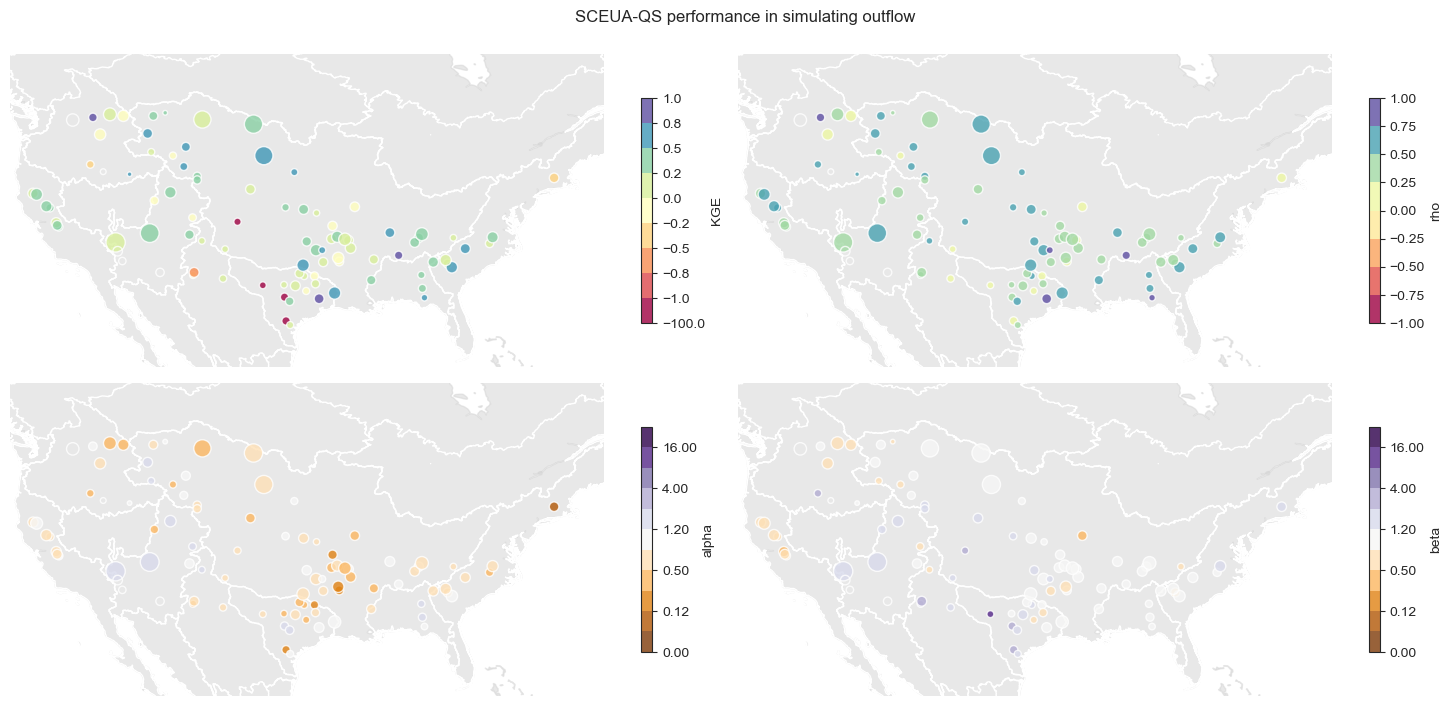

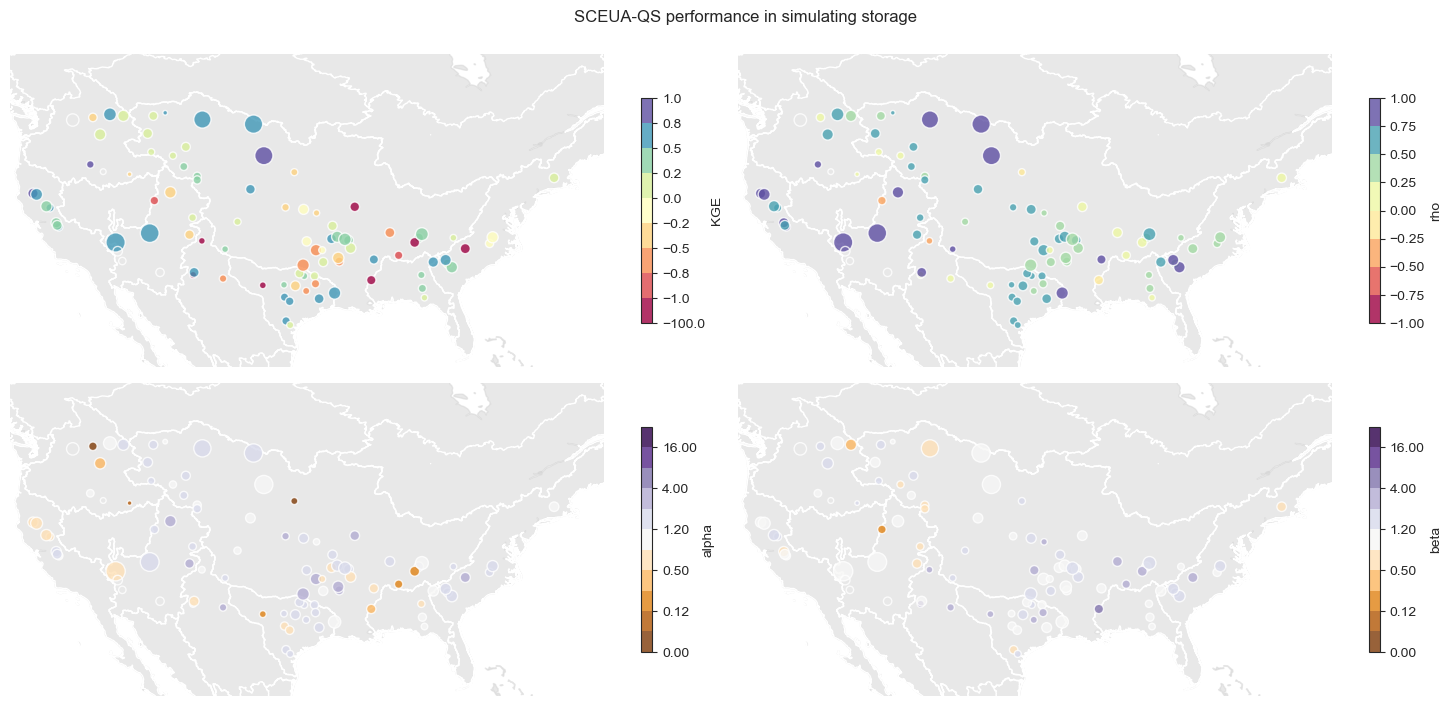

In [196]:
for sampling in list(performance):
    for var in performance.variable.data:

        fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 7), tight_layout=True, subplot_kw={'projection': proj})

        for i, metric in enumerate(['KGE', 'rho', 'alpha', 'beta']):

            if metric == 'KGE':
                cmap, norm = create_cmap('Spectral', [-100, -1, -.75, -.5, -.25 ,0, .25, .5, .75, 1])
            elif metric in ['alpha', 'beta']:
                cmap, norm = create_cmap('PuOr', [1e-6, 1/16, 1/8, 1/4, 1/2, 1/1.2, 1.2, 2, 4, 8, 16, 1e6])
            elif metric == 'rho':
                cmap, norm = create_cmap('Spectral', [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1])

            # background map
            ax = axes[int(i / 2), i % 2]
            ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
            catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
            ax.set_extent(extent)
            ax.axis('off')

            # scatter plot
            sct = ax.scatter(reservoirs.geometry.x,
                             reservoirs.geometry.y,
                             c=performance[sampling].sel(variable=var, metric=metric, ResID=reservoirs.index).data,
                             cmap=cmap, norm=norm, edgecolor='w', lw=1, 
                              s=reservoirs.CAP**.5, alpha=.8)
            # # setup: color bar, title...
            cbar = plt.colorbar(sct, ax=ax, shrink=.66)#, orientation='horizontal')
            cbar.set_label(metric, rotation=90)

        fig.text(.5, 1.0, f'{sampling} performance in simulating {var}', ha='center', va='bottom', fontsize=12);
        
        plt.savefig(PATH_OUT / f'maps_performance_{sampling}_{var}.jpg', dpi=300, bbox_inches='tight')

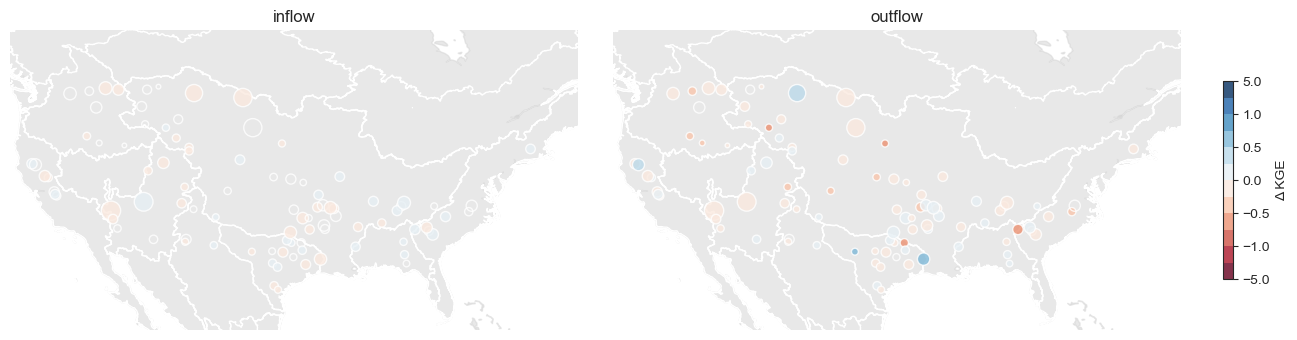

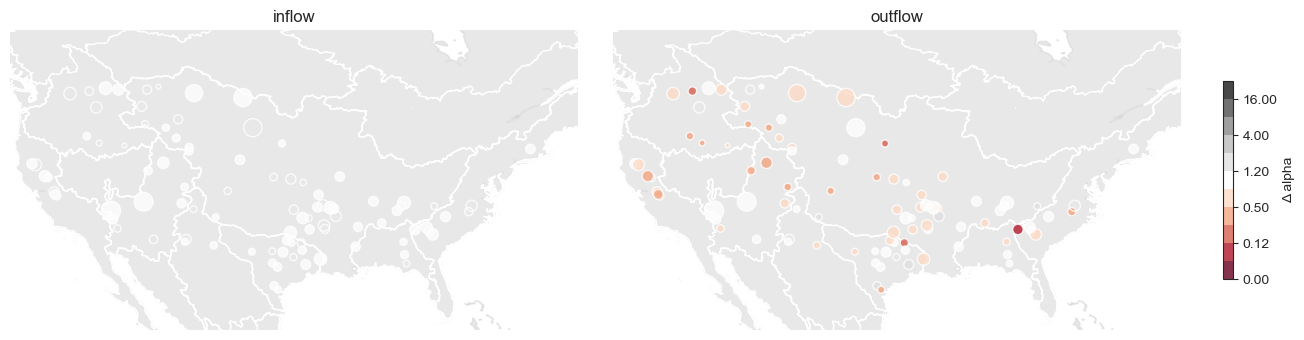

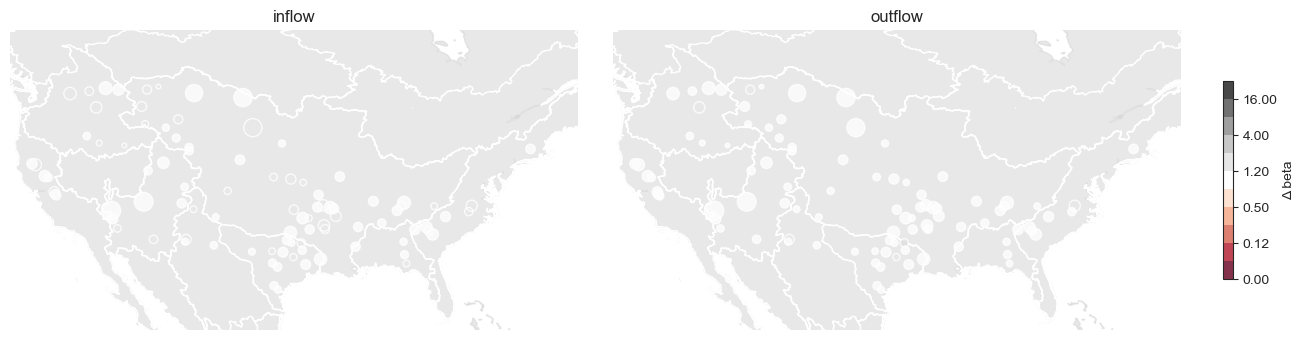

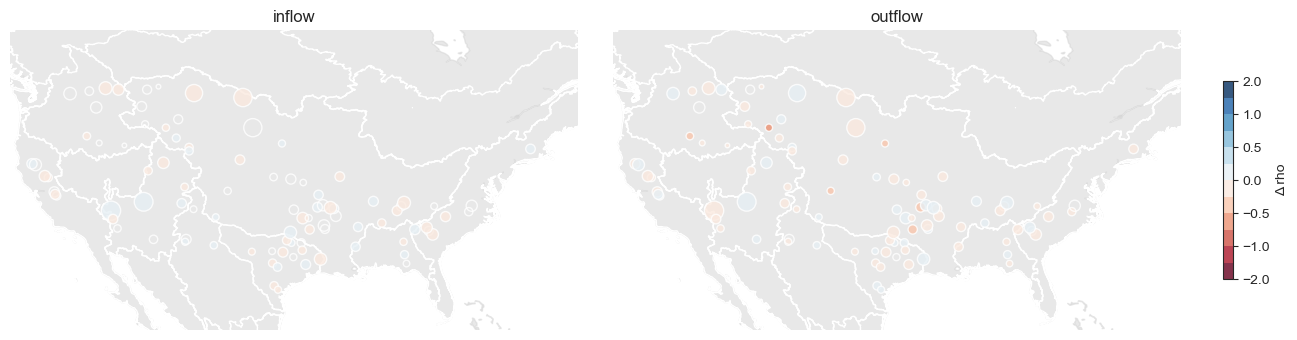

In [209]:
sampling = 'SCEUA-QS'

for metric in performance.metric.data:

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3.5), tight_layout=True, subplot_kw={'projection': proj})

    for ax, var in zip(axes, performance.variable.data):

        benchmark = performance['GloFAS'].sel(variable=var).to_pandas()
        calibration = performance[sampling].sel(variable=var).to_pandas()

        if metric in ['KGE', 'rho']:
            change = calibration - benchmark
        elif metric in ['alpha', 'beta']:
            change = calibration / benchmark

        if metric == 'KGE':
            cmap, norm = create_cmap('RdBu', [-5, -2, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 2, 5])
        elif metric in ['alpha', 'beta']:
            cmap, norm = create_cmap('RdGy', [1e-6, 1/16, 1/8, 1/4, 1/2, 1/1.2, 1.2, 2, 4, 8, 16, 1e6])
        elif metric == 'rho':
            cmap, norm = create_cmap('RdBu', [-2, -1.5, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 1.5 , 2])

        # background map
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
        catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
        ax.set_extent(extent)
        ax.set_title(var)
        ax.axis('off')

        # scatter plot
        sct = ax.scatter(reservoirs.geometry.x,
                         reservoirs.geometry.y,
                         c=change[metric],
                         cmap=cmap, norm=norm, edgecolor='w', lw=1, 
                          s=reservoirs.CAP**.5, alpha=.8)
    # # setup: color bar, title...
    cbar = fig.colorbar(sct, ax=ax, shrink=.66)#, orientation='horizontal')
    cbar.set_label(f'Δ {metric}', rotation=90)
    
    plt.savefig(PATH_OUT / f'maps_improvement_{sampling}_{metric}.jpg', dpi=300, bbox_inches='tight')

### Optimized parameters

In [264]:
parameters

<xarray.Dataset>
Dimensions:    (ResID: 94, parameter: 1)
Coordinates:
  * ResID      (ResID) int64 7 12 14 16 17 18 31 ... 534 581 609 617 621 635 638
  * parameter  (parameter) object 'T'
Data variables:
    default    (ResID, parameter) float64 725.7 447.0 242.4 ... 940.9 1.039e+03
    SCEUA-Q    (ResID, parameter) float64 1.096e+03 1.098e+03 ... 434.3 406.9
    SCEUA-S    (ResID, parameter) float64 783.0 101.2 119.3 ... 543.6 683.6
    SCEUA-QS   (ResID, parameter) float64 951.5 103.2 121.7 ... 509.9 633.8

15000.0

In [284]:
vmax / 10**r

0.14462175876564695

In [283]:
vmax

14462.175876564695

In [277]:
parameters.max()

<xarray.Dataset>
Dimensions:   ()
Data variables:
    default   float64 1.446e+04
    SCEUA-Q   float64 1.1e+03
    SCEUA-S   float64 1.1e+03
    SCEUA-QS  float64 1.1e+03

[(-720.8511158571206, 15000.0), (39.73452849999999, 15000.0)]

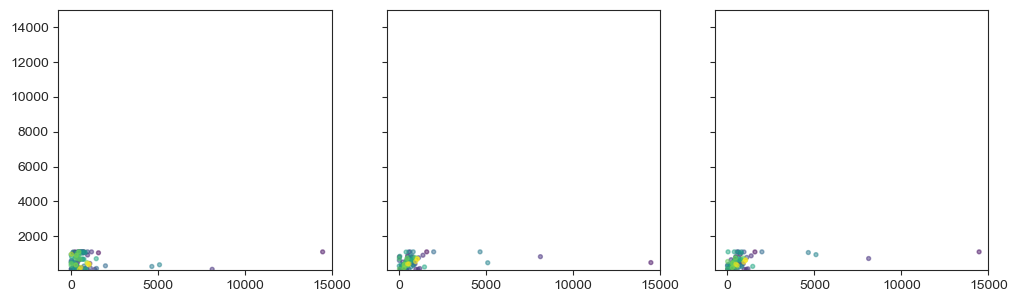

In [315]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3.75), sharex=True, sharey=True)

vmax = np.max([da.max() for cal, da in parameters.items()])
r = len(str(int(vmax))) - 2
vmax = np.ceil(vmax / 10**r) * 10**r

for ax, cal in zip(axes, ['SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']):
    ax.scatter(parameters['default'], parameters[cal], c=parameters['ResID'], s=8, cmap='viridis', alpha=.5)
    ax.set_aspect('equal')
    
ax.set(xlim=(None, vmax),
       ylim=(None, vmax))

In [321]:
performance['default'].sel(ResID=32).to_pandas()

metric       KGE  alpha    beta    rho
variable                              
inflow       NaN    NaN     NaN    NaN
outflow  -13.722  0.595  15.696  0.224
storage   -2.450  0.074   4.031 -0.364

In [322]:
performance['SCEUA-S'].sel(ResID=32).to_pandas()

metric       KGE  alpha    beta    rho
variable                              
inflow       NaN    NaN     NaN    NaN
outflow  -14.257  0.338  16.224  0.233
storage   -0.284  0.475   1.994  0.379

In [324]:
performance['SCEUA-QS'].sel(ResID=32).to_pandas()

metric       KGE  alpha    beta    rho
variable                              
inflow       NaN    NaN     NaN    NaN
outflow  -13.830  0.543  15.803  0.222
storage   -1.812  0.201   3.516  0.032

In [318]:
(parameters['default'].sel(parameter='T') > 1100).sum()

<xarray.DataArray 'default' ()>
array(11)
Coordinates:
    parameter  <U1 'T'

In [310]:
parameters['default'].sel(parameter='T', ResID=32)

<xarray.DataArray 'default' ()>
array(14462.17587656)
Coordinates:
    ResID      int64 32
    parameter  <U1 'T'

In [312]:
reservoirs.loc[32]

GLWD_ID                         3669.0
GRAND_ID                          1243
Source                            GLWD
LAKE_NAME       E. V. Spence Reservoir
DAM_NAME      Robert Lee (Spence[res])
LONG_DEG                       -100.57
LAT_DEG                          31.93
LONG_OUTLE                         NaN
LAT_OUTLET                         NaN
VOLUME_Gra                         NaN
VOL_SRC                      ICOLD_LRs
COUNTRY                  United States
SEC_CNTRY                         None
RIVER                         Colorado
NEAR_CITY                   Robert Lee
DAM_YEAR                          1969
note                              None
X_coord                        -100.55
Y_coord                          31.95
X_CORRECT                      -100.55
Y_CORRECT                        31.95
LisfloodX3                    -100.525
LisfloodY3                      31.925
remap_com                     remapped
clim                               0.1
flim                     

In [299]:
par_space

{'T': (90, 1100)}

In [303]:
parameters['SCEUA-S'].sel(parameter='T')

<xarray.DataArray 'SCEUA-S' (ResID: 94)>
array([ 782.97125 ,  101.187164,  119.27076 ,  194.97534 , 1099.661   ,
        864.53503 ,  174.7256  ,  483.1999  ,  350.56918 ,  550.9048  ,
         92.0035  ,  810.9609  ,  474.22797 ,   90.22472 ,   94.11511 ,
         92.04381 ,  903.8274  ,  405.14447 ,  822.35156 ,  139.10448 ,
        514.3274  ,  292.14413 ,  761.8631  ,  664.5023  ,  237.46342 ,
        502.9779  , 1093.2959  ,  137.00618 ,  606.27814 ,  637.6077  ,
        431.87534 ,  120.6797  ,  143.25969 ,  495.2353  ,  275.2649  ,
       1099.152   ,         nan, 1099.961   ,  222.83739 ,  166.57239 ,
        326.2159  ,         nan,         nan,  559.4262  ,  855.15393 ,
        109.93648 ,  352.30737 ,  421.06656 , 1099.7412  , 1099.8215  ,
        212.06154 ,  228.65108 ,  350.95032 ,  471.93393 ,  178.18164 ,
         92.06259 ,  114.032845,  288.0428  ,  818.25244 ,  651.70966 ,
        367.80267 ,         nan,  636.8342  ,  576.416   ,  184.66621 ,
       1087.8828  ,  230.07726 ,  842.42523 ,  282.7851  ,  741.1168  ,
        759.5276  ,  279.34164 ,  598.82745 ,         nan,  329.38123 ,
        587.3339  ,  327.23444 ,  546.9713  ,  714.05914 ,  308.87546 ,
        351.45236 ,  325.66788 ,  399.54117 ,  776.1309  ,  111.890854,
        715.631   ,  368.13315 ,  168.9729  ,         nan,  702.64526 ,
        410.70856 ,  404.38538 ,  543.5731  ,  683.5968  ])
Coordinates:
  * ResID      (ResID) int64 7 12 14 16 17 18 31 ... 534 581 609 617 621 635 638
    parameter  <U1 'T'

In [289]:
par = 'T'
sampling = 'SCEUA-QS'
use = 'Hydroelectricity'

In [291]:
ResIDs = list(set(mask_KGE).intersection(reservoirs[reservoirs.MAIN_USE == use].index))

ResIDs

[228, 422, 423, 392, 504, 635, 348]

In [297]:
parameters[sampling].sel(ResID=ResIDs).dropna('ResID')

<xarray.DataArray 'SCEUA-QS' (ResID: 5, parameter: 1)>
array([[336.7923 ],
       [327.86005],
       [299.04553],
       [739.85065],
       [509.87592]])
Coordinates:
  * ResID      (ResID) int64 228 423 392 504 635
  * parameter  (parameter) object 'T'

In [ ]:
da.sel(parameter=par, ResID=ResIDs).data

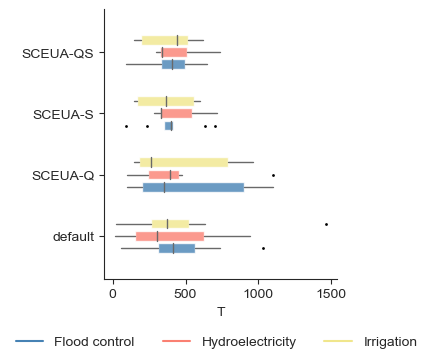

In [298]:
mask_KGE = reservoirs.loc[KGE_bivar['SCEUA-QS'] > 0].index

color_mapping = {'Flood control': 'steelblue', 'Hydroelectricity': 'salmon', 'Irrigation': 'khaki'}
w = .2

n_pars = len(parameters.parameter)
fig, axes = plt.subplots(ncols=n_pars, figsize=(3 * n_pars, 3.5), sharey=True)
if not isinstance(axes, list):
    axes = [axes]
for ax, par in zip(axes, parameters.parameter.data):
    yticks, yticklabels = [], []
    for i, (sampling, da) in enumerate(parameters.items(), start=1):
        # print(i, sampling)
        yticks.append(i)
        yticklabels.append(sampling)
        for j, use in enumerate(['Flood control', 'Hydroelectricity', 'Irrigation']):
            ResIDs = list(set(mask_KGE).intersection(reservoirs[reservoirs.MAIN_USE == use].index))
            box_color = color_mapping[use]
            ax.boxplot(da.sel(parameter=par, ResID=ResIDs).dropna('ResID').data,
                       positions=[i + (j - 1) * w],
                       widths=w * .8,
                       vert=False,
                       patch_artist=True,
                       boxprops=dict(facecolor=box_color, edgecolor=None, alpha=.8),
                       medianprops={'color': 'dimgray'},
                       whiskerprops=dict(color='dimgray', linestyle='-'),
                       showcaps=False,
                       flierprops=dict(marker='.', markersize=2)
                      )
            ax.plot([], color=box_color, label=use)
    ax.set(xlabel=par)
    ax.spines[['right', 'top']].set_visible(False)
    #if ax == axes[0]:
    #    ax.set_ylabel('sampling')
ax.set_yticks(ticks=yticks, labels=yticklabels)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], frameon=False, loc=8, ncol=3, bbox_to_anchor=[.333, -.125, .333, .05]);

plt.savefig(PATH_OUT / 'optimized_parameters.jpg', dpi=300, bbox_inches='tight')

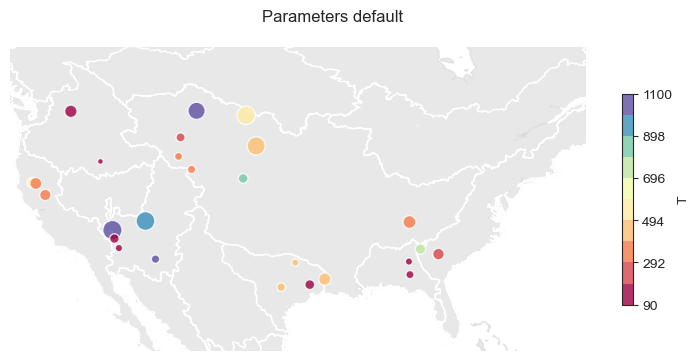

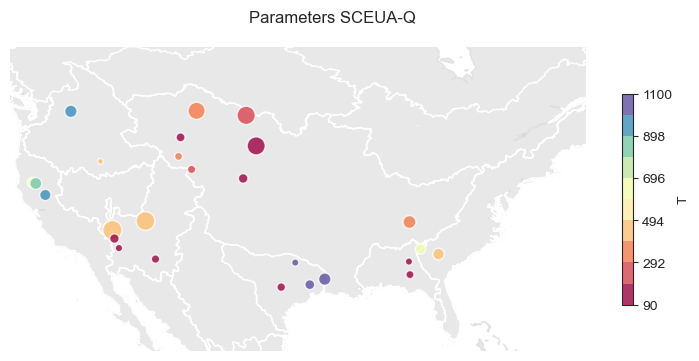

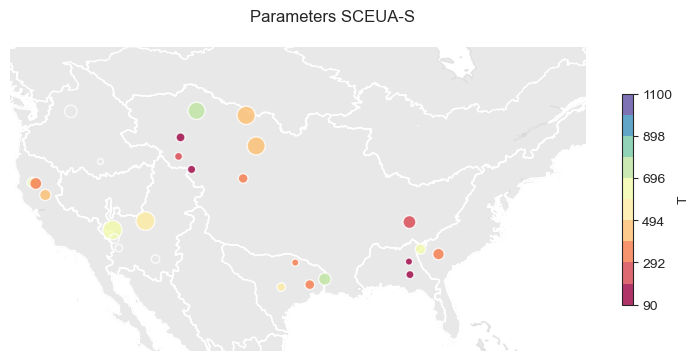

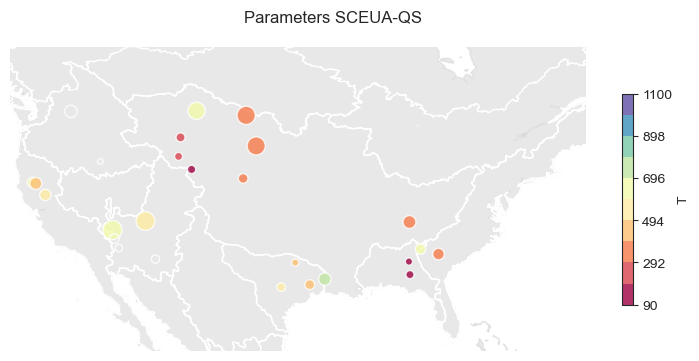

In [241]:
sampling = 'SCEUA-QS'

if n_pars < 2:
    ncols = n_pars
else:
    ncols = 2
nrows = int(np.ceil(n_pars / ncols))

for sampling, da in parameters.items():

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(7.5 * ncols, 3.5 * nrows), tight_layout=True, subplot_kw={'projection': proj})
    
    for i, par in enumerate(parameters.parameter.data):

        try:
            ax = axes[int(i / 2), i % 2]
        except:
            ax = axes
        ax.set_extent(extent)
        catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
        ax.axis('off')

        # background map
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
        # scatter plot
        cmap, norm = create_cmap('Spectral', np.linspace(*par_space[par], 11))
        sct = ax.scatter(reservoirs.loc[mask_KGE].geometry.x,
                         reservoirs.loc[mask_KGE].geometry.y,
                         c=parameters[sampling].sel(parameter=par, ResID=mask_KGE).data,
                         s=reservoirs.loc[mask_KGE].CAP**.5, 
                         cmap=cmap, norm=norm, edgecolor='w', lw=1,  alpha=.8)
        # # setup: color bar, title...
        cbar = plt.colorbar(sct, ax=ax, shrink=.66)#, orientation='horizontal')
        cbar.set_label(par, rotation=90)

    fig.text(.45, 1.0, f'Parameters {sampling}', ha='center', va='bottom', fontsize=12);
    plt.savefig(PATH_OUT / f'maps_parameters_{sampling}.jpg', dpi=300, bbox_inches='tight')

Create a map of the difference in the parameters between GloFAS a SCEUA-QS.